In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, activation="sigmoid", input_shape=(1,)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [3]:
@tf.function()
def action_selection(model):
    with tf.GradientTape() as tape:
        output = model(np.array([[0.0]]))  # [0 ... 1]
        action = (tf.random.uniform((1, 1)) < output)  # [0 or 1]

        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(action, output))

    grads = tape.gradient(loss, model.trainable_variables)
    return output, action, loss, grads

In [4]:
STEPS = 1000
LR = 0.5

In [5]:
for step in range(STEPS):

    output, action, loss, grads = action_selection(model)
    if action == False:  # Action A
        reward = float(np.random.random() < 0.3)

    if action == True:  # Action B
        reward = float(np.random.random() < 0.4)

    grads_adjusted = []
    for var_index in range(len(model.trainable_variables)):
        grads_adjusted.append((reward-0.5)*2 * grads[var_index])

    model.trainable_variables[0].assign(model.trainable_variables[0]-LR*grads_adjusted[0])
    model.trainable_variables[1].assign(model.trainable_variables[1]-LR*grads_adjusted[1])

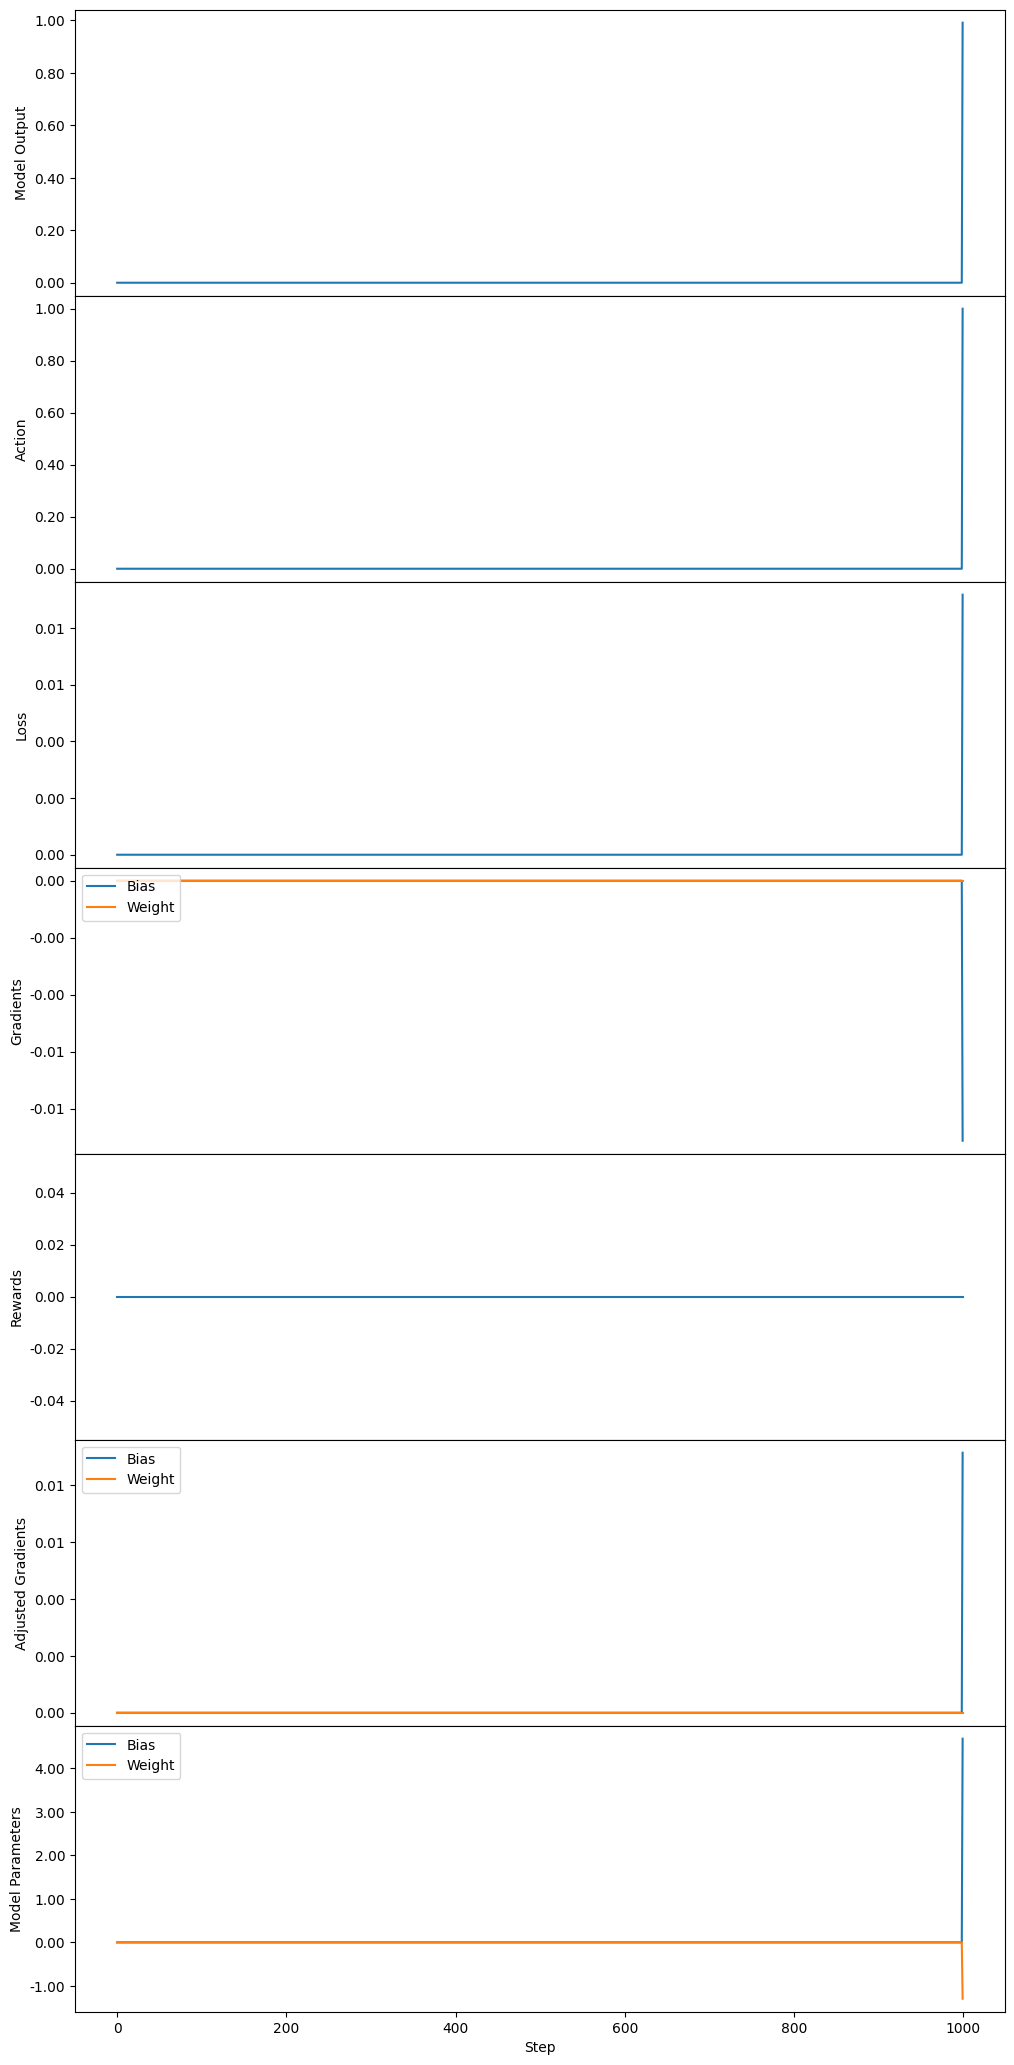

In [12]:
import copy


information_for_plotting = np.zeros((STEPS, 10))
information_for_plotting[step, 0] = output.numpy()[0]
information_for_plotting[step, 1] = action.numpy()[0].astype(int)
information_for_plotting[step, 2] = loss
information_for_plotting[step, 3] = grads[0]
information_for_plotting[step, 4] = grads[1]
information_for_plotting[step, 5] = reward
information_for_plotting[step, 6] = grads_adjusted[0]
information_for_plotting[step, 7] = grads_adjusted[1]
information_for_plotting[step, 8] = copy.deepcopy(model.trainable_variables[0])
information_for_plotting[step, 9] = copy.deepcopy(model.trainable_variables[1])
    
# Plot the results
titles = ['Model Output', 'Action', 'Loss', 'Gradients', 'Rewards',
          'Adjusted Gradients', 'Model Parameters']
plus = [0, 0, 0, 0, 1, 1, 2]

fig = plt.figure(figsize=(12, 26))
fig.subplots(7, 1, sharex=True)
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.subplots_adjust(hspace=.0)

    if i in [0, 1, 2, 4]:
        plt.plot(information_for_plotting[:, i+plus[i]])
        plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    else:
        plt.plot(information_for_plotting[:, i+1+plus[i]], label='Bias')
        plt.plot(information_for_plotting[:, i+plus[i]], label='Weight')

        plt.legend(loc="upper left")
        plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    plt.ylabel(titles[i])

plt.xlabel('Step')
plt.show()